In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

## Data

In [2]:
!pip install -q ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

def get_data_from_uci(id=144):
    statlog_german_credit_data = fetch_ucirepo(id=144)

    X = statlog_german_credit_data.data.features
    y = statlog_german_credit_data.data.targets

    return X, y

X, y = get_data_from_uci(144)

In [4]:
X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201


In [5]:
le = [
    'Attribute1',
    'Attribute3',
    'Attribute4',
    'Attribute6',
    'Attribute7',
    'Attribute9',
    'Attribute10',
    'Attribute12',
    'Attribute14',
    'Attribute15',
    'Attribute17',
    'Attribute19',
    'Attribute20',
]

## Benchmarks

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
bX, by = X.copy(), y.copy()

label_enc = LabelEncoder()
label_enc.fit(bX[le].to_numpy().flatten())
for col in le:
    bX.loc[:, (col)] = label_enc.transform(bX[col])

norm = StandardScaler()
norm.fit(bX)
bX = pd.DataFrame(data=norm.transform(bX), columns=bX.columns)

# norm = RobustScaler()
# norm.fit(bX)
# bX = pd.DataFrame(data=norm.transform(bX), columns=bX.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(bX, by, test_size=0.33,
                                                    random_state=42)

In [ ]:
def get_benchmarks():
    benchmarks_acc = {}

    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, y_train.to_numpy().ravel())
    benchmarks_acc['LogReg'] = accuracy_score(y_test, clf.predict(X_test))

    neigh = KNeighborsClassifier(n_neighbors=10)
    neigh.fit(X_train, y_train.to_numpy().ravel())
    benchmarks_acc['KNN'] = accuracy_score(y_test, neigh.predict(X_test))

    rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
    rf.fit(X_train, y_train.to_numpy().ravel())
    benchmarks_acc['RandForest'] = accuracy_score(y_test, rf.predict(X_test))

    return pd.DataFrame(data=benchmarks_acc.values(),
                        index=benchmarks_acc.keys(),
                        columns=['Accuracy'])


In [ ]:
get_benchmarks()

,Accuracy
LogReg,0.766667
KNN,0.760606
RandForest,0.760606


## K-means

In [6]:
label_enc = LabelEncoder()
label_enc.fit(X[le].to_numpy().flatten())

for col in le:
    X.loc[:, (col)] = label_enc.transform(X[col])


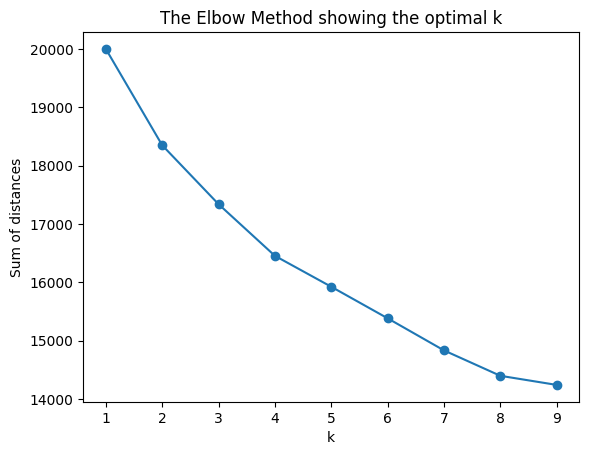

In [ ]:
norm = StandardScaler()
norm.fit(X)
df = norm.transform(X)

K = range(1, 10)
models = [KMeans(n_clusters=k).fit(df) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [7]:
norm = StandardScaler()
DATA = {
    'all data': norm.fit_transform(X),
    'without label encoder data': norm.fit_transform(X.loc[:, ~X.columns.isin(le)]),
    'only label encoder data': norm.fit_transform(X[le])
}

robust = RobustScaler()
robust_DATA = {
    'all data': robust.fit_transform(X),
    'without label encoder data': robust.fit_transform(X.loc[:, ~X.columns.isin(le)]),
    'only label encoder data': robust.fit_transform(X[le])
}

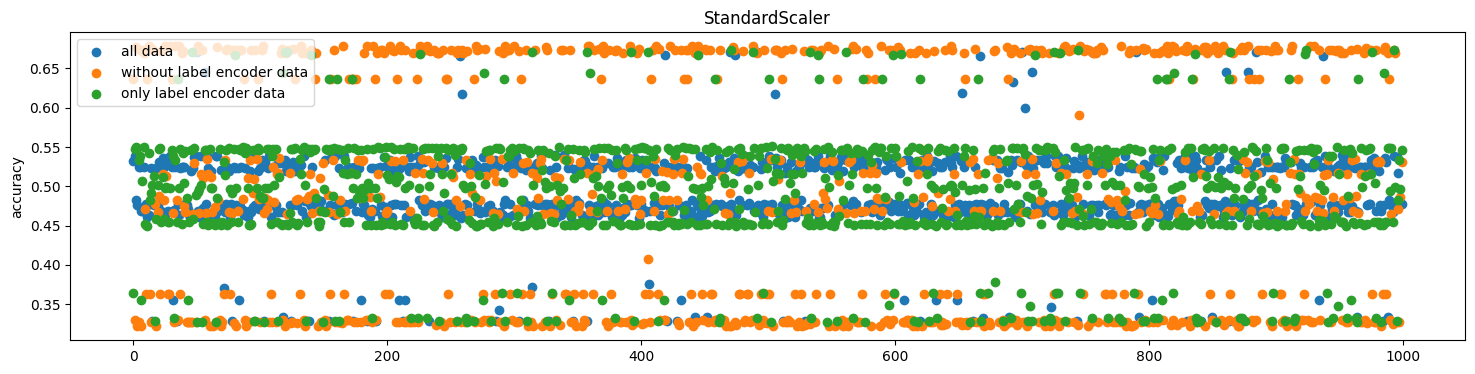

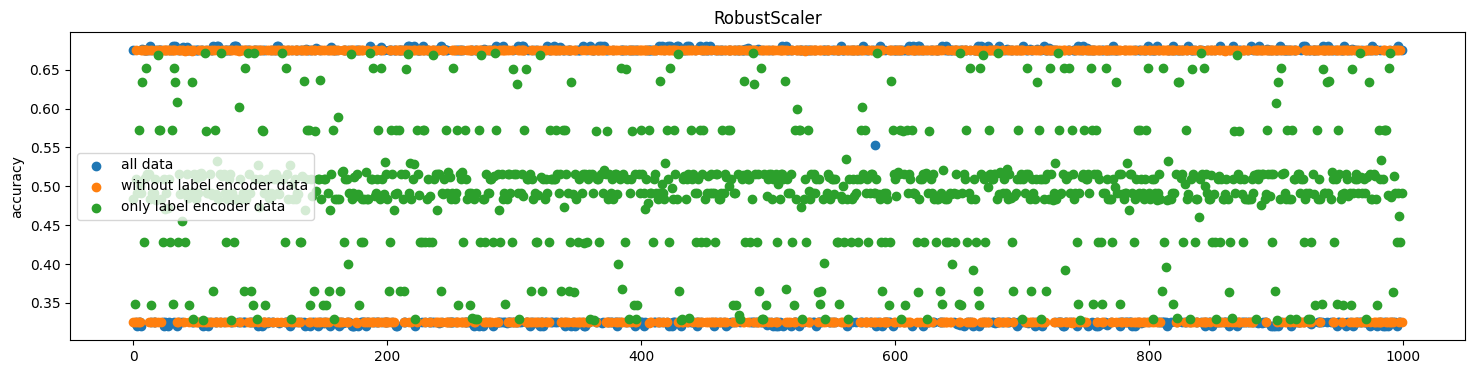

In [ ]:
acc_results = {
    'StandardScaler': defaultdict(list),
    'RobustScaler': defaultdict(list),
}

model = KMeans(n_clusters=2)


plt.figure(figsize=(18, 4))
for key, data in DATA.items():
    for _ in range(1_000):
        model.fit(data)
        acc_results['StandardScaler'][key].append(accuracy_score(y, model.labels_+1))

    plt.scatter(np.arange(1_000), acc_results['StandardScaler'][key], label=key)

plt.title('StandardScaler')
plt.ylabel('accuracy')
plt.legend()


plt.figure(figsize=(18, 4))
for key, data in robust_DATA.items():
    for _ in range(1_000):
        model.fit(data)
        acc_results['RobustScaler'][key].append(accuracy_score(y, model.labels_+1))

    plt.scatter(np.arange(1_000), acc_results['RobustScaler'][key], label=key)

plt.title('RobustScaler')
plt.ylabel('accuracy')
plt.legend()


In [ ]:
for scaler, results in acc_results.items():
    print(scaler)
    for key, value in results.items():
        print(key)
        print(f'max: {np.max(value)}, min: {np.min(value)}, median: {round(np.mean(value), 4)}')
        print('='*50)
    print()

StandardScaler
all data
max: 0.671, min: 0.329, median: 0.4913
without label encoder data
max: 0.678, min: 0.322, median: 0.4884
only label encoder data
max: 0.673, min: 0.327, median: 0.4902

RobustScaler
all data
max: 0.68, min: 0.32, median: 0.5065
without label encoder data
max: 0.675, min: 0.324, median: 0.5406
only label encoder data
max: 0.672, min: 0.328, median: 0.4937



## Change number of columns

In [ ]:
df = pd.DataFrame(data=norm.fit_transform(X[le]), columns=X[le].columns)
df.head()

,Attribute1,Attribute3,Attribute4,Attribute6,Attribute7,Attribute9,Attribute10,Attribute12,Attribute14,Attribute15,Attribute17,Attribute19,Attribute20
0,-1.063596,1.344014,0.264068,1.833169,1.338078,0.449326,-0.303686,-1.293723,0.460831,0.133710,0.146949,1.214598,-0.196014
1,-0.751233,-0.503428,0.264068,-0.699707,-0.317959,-0.963650,-0.303686,-1.293723,0.460831,0.133710,0.146949,-0.823318,-0.196014
2,1.122945,1.344014,1.359785,-0.699707,0.510060,0.449326,-0.303686,-1.293723,0.460831,0.133710,-1.383771,-0.823318,-0.196014
3,-1.063596,-0.503428,-0.101171,-0.699707,0.510060,0.449326,3.885083,-0.341055,0.460831,2.016956,0.146949,-0.823318,-0.196014
4,-1.063596,0.420293,-1.196889,-0.699707,-0.317959,0.449326,-0.303686,1.564281,0.460831,2.016956,0.146949,-0.823318,-0.196014


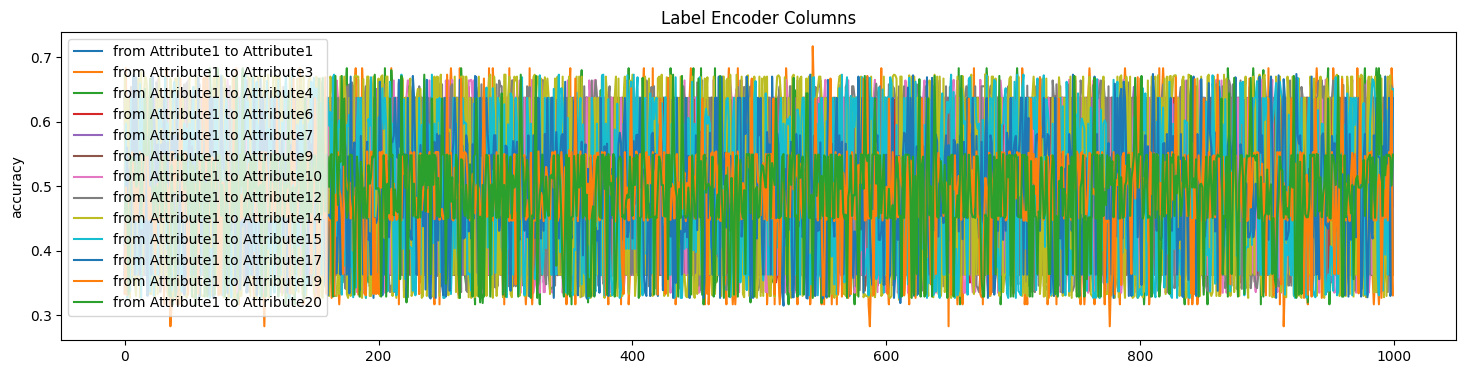

In [ ]:
model = KMeans(n_clusters=2)

acc_results = defaultdict(list)
plt.figure(figsize=(18, 4))
for col in df.columns:
    for _ in range(1_000):
        model.fit(df.loc[:, df.columns[0]:col])
        acc_results[col].append(accuracy_score(y, model.labels_+1))

    plt.plot(np.arange(1_000), acc_results[col], label=f'from {df.columns[0]} to {col}')

plt.title('Label Encoder Columns')
plt.ylabel('accuracy')
plt.legend()

In [ ]:
acc_df = pd.DataFrame(data=acc_results)
acc_df.head()

,Attribute1,Attribute3,Attribute4,Attribute6,Attribute7,Attribute9,Attribute10,Attribute12,Attribute14,Attribute15,Attribute17,Attribute19,Attribute20
0,0.363,0.514,0.637,0.363,0.637,0.363,0.335,0.637,0.672,0.408,0.363,0.333,0.455
1,0.637,0.683,0.637,0.637,0.367,0.363,0.637,0.346,0.333,0.597,0.473,0.498,0.486
2,0.637,0.363,0.637,0.363,0.637,0.637,0.637,0.336,0.637,0.327,0.560,0.331,0.468
3,0.363,0.637,0.363,0.637,0.372,0.401,0.363,0.346,0.637,0.403,0.427,0.448,0.333
4,0.637,0.637,0.581,0.637,0.373,0.363,0.363,0.363,0.327,0.338,0.527,0.504,0.451


In [ ]:
acc_df.max()

,0
Attribute1,0.637
Attribute3,0.717
Attribute4,0.683
Attribute6,0.654
Attribute7,0.654
Attribute9,0.648
Attribute10,0.665
Attribute12,0.664
Attribute14,0.677
Attribute15,0.673


In [ ]:
acc_df.mean()

,0
Attribute1,0.487122
Attribute3,0.491496
Attribute4,0.498826
Attribute6,0.497257
Attribute7,0.489273
Attribute9,0.484242
Attribute10,0.494447
Attribute12,0.489319
Attribute14,0.493005
Attribute15,0.492459


In [ ]:
acc_df.min()

,0
Attribute1,0.363
Attribute3,0.283
Attribute4,0.317
Attribute6,0.346
Attribute7,0.347
Attribute9,0.338
Attribute10,0.335
Attribute12,0.329
Attribute14,0.324
Attribute15,0.327


Text(0, 0.5, 'accuracy')

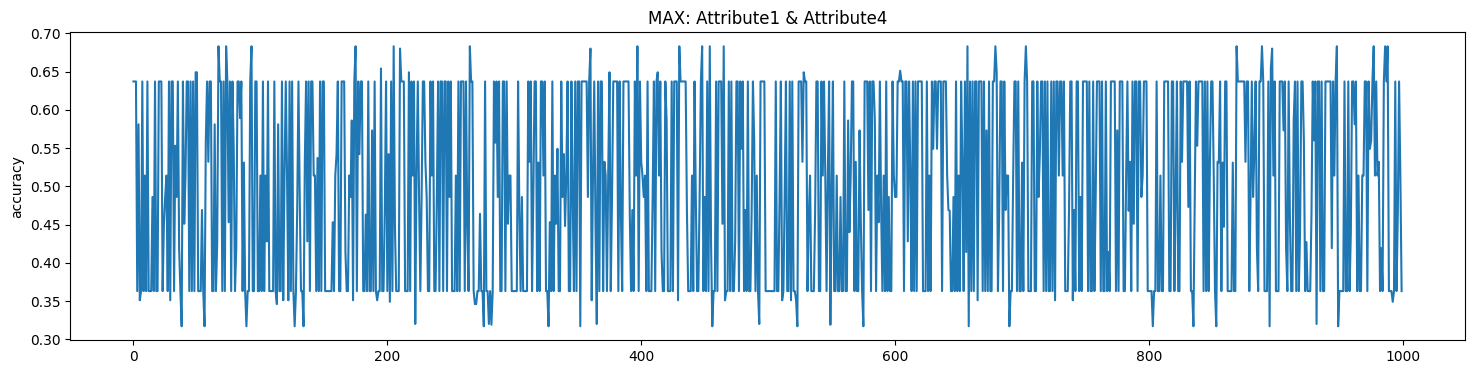

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(np.arange(1_000), acc_df['Attribute4'])
plt.title('MAX: Attribute1 & Attribute4')
plt.ylabel('accuracy')

In [12]:
df = pd.DataFrame(data=norm.fit_transform(X.loc[:, ~X.columns.isin(le)]),
                  columns=X.loc[:, ~X.columns.isin(le)].columns)
df.head()

,Attribute2,Attribute5,Attribute8,Attribute11,Attribute13,Attribute16,Attribute18
0,-1.236478,-0.745131,0.918477,1.046987,2.766456,1.027079,-0.428290
1,2.248194,0.949817,-0.870183,-0.765977,-1.191404,-0.704926,-0.428290
2,-0.738668,-0.416562,-0.870183,0.140505,1.183312,-0.704926,2.334869
3,1.750384,1.634247,-0.870183,1.046987,0.831502,-0.704926,2.334869
4,0.256953,0.566664,0.024147,1.046987,1.535122,1.027079,2.334869


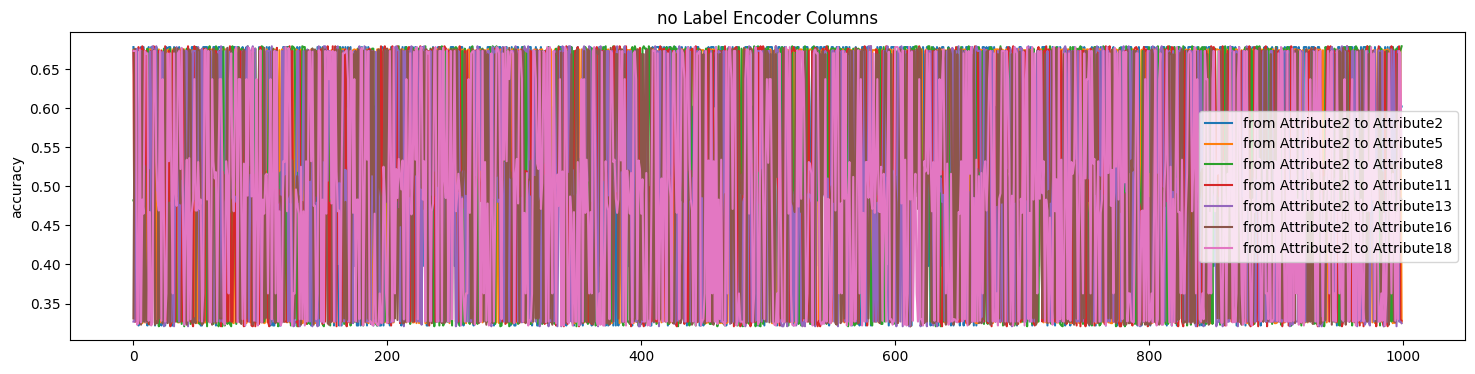

In [13]:
model = KMeans(n_clusters=2)

acc_results = defaultdict(list)
plt.figure(figsize=(18, 4))
for col in df.columns:
    for _ in range(1_000):
        model.fit(df.loc[:, df.columns[0]:col])
        acc_results[col].append(accuracy_score(y, model.labels_+1))

    plt.plot(np.arange(1_000), acc_results[col], label=f'from {df.columns[0]} to {col}')

plt.title('no Label Encoder Columns')
plt.ylabel('accuracy')
plt.legend()

In [14]:
acc_df = pd.DataFrame(data=acc_results)
acc_df.head()

,Attribute2,Attribute5,Attribute8,Attribute11,Attribute13,Attribute16,Attribute18
0,0.678,0.674,0.482,0.673,0.327,0.331,0.673
1,0.602,0.674,0.482,0.327,0.327,0.676,0.673
2,0.602,0.674,0.673,0.327,0.673,0.669,0.673
3,0.398,0.675,0.327,0.673,0.676,0.479,0.323
4,0.322,0.675,0.327,0.678,0.328,0.325,0.328


In [18]:
pd.DataFrame({'max': acc_df.max(), 'mean': acc_df.mean(), 'min': acc_df.min()})

,max,mean,min
Attribute2,0.678,0.536276,0.322
Attribute5,0.675,0.557684,0.325
Attribute8,0.679,0.522925,0.321
Attribute11,0.679,0.516925,0.321
Attribute13,0.679,0.502462,0.321
Attribute16,0.677,0.491174,0.323
Attribute18,0.678,0.491817,0.322


In [20]:
selected_columns = ['Attribute1', 'Attribute3', 'Attribute4', 'Attribute2', 'Attribute5']
X[selected_columns].head()

,Attribute1,Attribute3,Attribute4,Attribute2,Attribute5
0,3,29,34,6,1169
1,4,27,34,48,5951
2,10,29,37,12,2096
3,3,27,33,42,7882
4,3,28,30,24,4870


<ipython-input-26-3f1350b8bef7>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


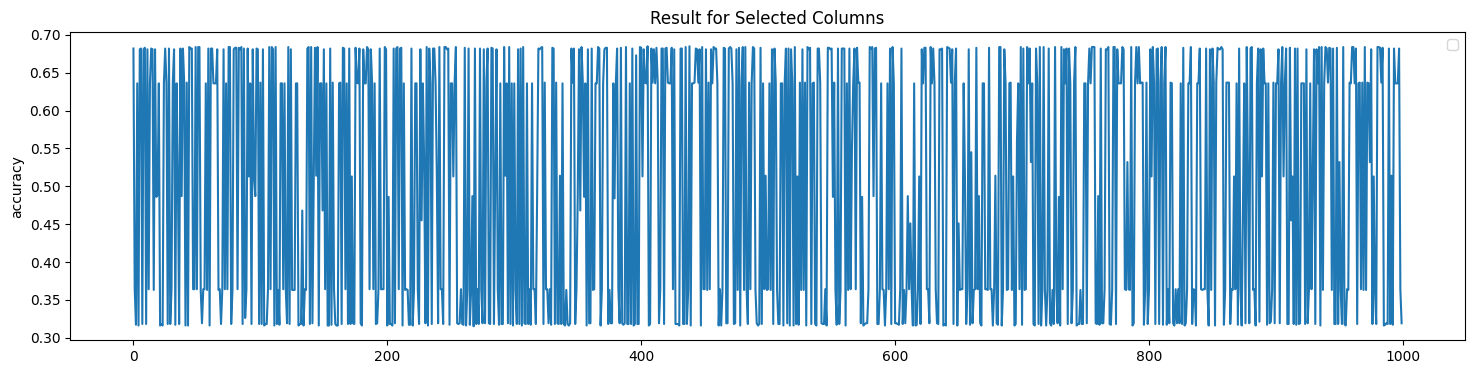

In [26]:
data = norm.fit_transform(X[selected_columns])

model = KMeans(n_clusters=2)

acc_results = []
plt.figure(figsize=(18, 4))

for _ in range(1_000):
    model.fit(data)
    acc_results.append(accuracy_score(y, model.labels_+1))

plt.plot(np.arange(1_000), acc_results)
plt.title('Result for Selected Columns')
plt.ylabel('accuracy')
plt.legend()

In [27]:
acc_df = pd.DataFrame(data=acc_results)
pd.DataFrame({'max': acc_df.max(), 'mean': acc_df.mean(), 'min': acc_df.min()})

,max,mean,min
0,0.685,0.498945,0.315


<ipython-input-28-f063272acaf2>:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


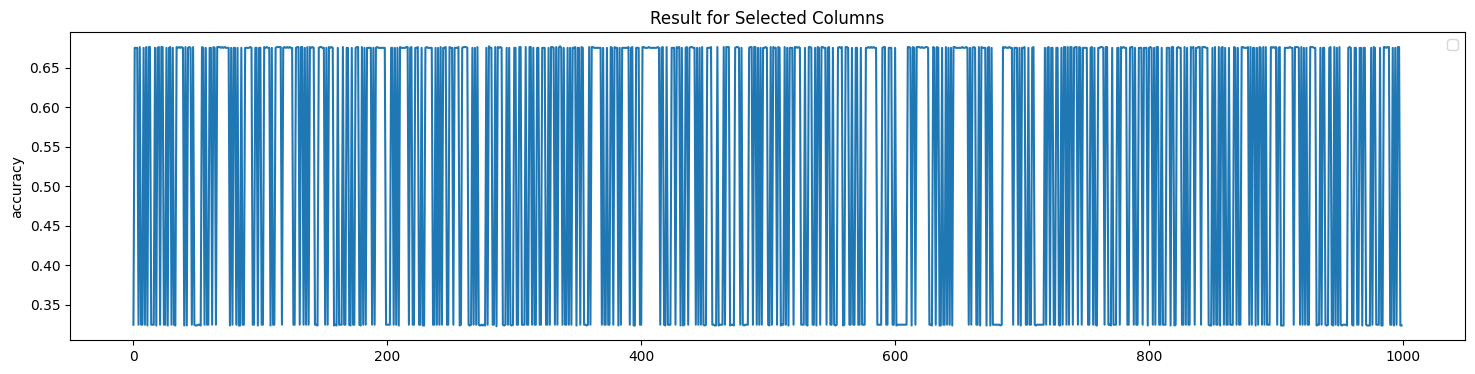

In [28]:
data = robust.fit_transform(X[selected_columns])

model = KMeans(n_clusters=2)

acc_results = []
plt.figure(figsize=(18, 4))

for _ in range(1_000):
    model.fit(data)
    acc_results.append(accuracy_score(y, model.labels_+1))

plt.plot(np.arange(1_000), acc_results)
plt.title('Result for Selected Columns')
plt.ylabel('accuracy')
plt.legend()

In [29]:
acc_df = pd.DataFrame(data=acc_results)
pd.DataFrame({'max': acc_df.max(), 'mean': acc_df.mean(), 'min': acc_df.min()})

,max,mean,min
0,0.677,0.527429,0.323
